# Bag of Words Model using pre-trained word embeddings

In [0]:
# data wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# language model 
import spacy
spacy_en = spacy.load('en')

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils import data

from collections import Counter
import copy
import re
import matplotlib.pyplot as plt
import matplotlib 

In [0]:
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Tokenizer and custom vocabularly class

In [0]:
def tokenizer(text): 
    text = text.lower()
    text = re.sub("-rrb-","", text)
    text = re.sub("-lrb-","", text)
    tokens = spacy_en.tokenizer(text)
    #tokens = [tok for tok in tokens if tok.is_stop == False]
    tokens = [tok.lemma_ for tok in tokens]
    return tokens

In [0]:
class Vocabulary:
      
    def __init__(self, vocabCount, min_freq):
        
        # UNK tokens (don't need pad token for bag-of-words)
        self.UNK_token = 0
        self.vocabCount = vocabCount
        self.min_freq = min_freq
        # initialize list of words and vocab dictionary
        self.wordlist = ["<unk>"]
        self.word2index = {}
        # build vocab
        self.build_vocab(vocabCount)

    def __len__(self):
        return len(self.word2index)

    def __getitem__(self, word):
        return self.word2index.get(word, 0)

    def __iter__(self):
        return iter(vocab.word2index)

    def build_vocab(self, vocabCount):
        # sort vocab s.t. words that occur most frequently added first
        svocabCount = {k: v for k, v in reversed(sorted(vocabCount.items(), 
                                                      key=lambda item: item[1]))}
        
        for word in svocabCount:
            if svocabCount[word] >= self.min_freq:
                self.wordlist.append(word)
        self.word2index.update({tok: i for i, tok in enumerate(self.wordlist)})

## Load data and tokenize

In [0]:
train_data = pd.read_csv('../data/train.tsv', sep="\t", encoding="utf_8_sig")
phrases = np.array(train_data.iloc[:, 2])
target = np.array(train_data.iloc[:, 3])

# create train and validation sets
X_train , X_val, y_train , y_val = train_test_split(phrases, target, 
                                                    test_size = 0.2, random_state=42)

# create validation and test sets
X_val , X_test, y_val , y_test = train_test_split(X_val, y_val, 
                                                    test_size = 0.4, random_state=42)

In [9]:
X_train = [tokenizer(phrase) for phrase in X_train]
X_val = [tokenizer(phrase) for phrase in X_val]
X_test = [tokenizer(phrase) for phrase in X_test]

print("Length of train dataset: {} \nLength of validation dataset: {} \nLength of test dataset: {}".format(len(X_train), len(X_val), len(X_test)))

Length of train dataset: 124848 
Length of validation dataset: 18727 
Length of test dataset: 12485


## Create vocabularly

In [0]:
vocabCount = Counter([item for sublist in X_train for item in sublist])

In [0]:
vocab = Vocabulary(vocabCount, 1)

In [0]:
X_trainNum = [torch.tensor([vocab[word] for word in phrase]) for phrase in X_train]
X_valNum = [torch.tensor([vocab[word] for word in phrase]) for phrase in X_val]
X_testNum = [torch.tensor([vocab[word] for word in phrase]) for phrase in X_test]

In [13]:
# make sure each tensor actually has values
for i, el in enumerate(X_trainNum):
    if el.nelement() == 0:
        print(i)
        X_trainNum[i] = torch.tensor([0]).long()

43785


In [0]:
# make sure each tensor actually has values
for i, el in enumerate(X_valNum):
    if el.nelement() == 0:
        print(i)
        X_valNum[i] = torch.tensor([0]).long()

In [15]:
# make sure each tensor actually has values
for i, el in enumerate(X_testNum):
    if el.nelement() == 0:
        print(i)
        X_testNum[i] = torch.tensor([0]).long()

7117


## Dataset class and batching function

In [0]:
class WordDataset(data.Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):  
        X = self.X[idx]
        Y = self.y[idx]
        return X, Y

In [0]:
def generate_batch(batch):
    
    # get data and targets from batch
    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    lengths = [len(el) for el in data]
    offsets = np.cumsum(lengths)
    offsets = np.concatenate([[0], offsets[:-1]])
  
    return torch.LongTensor(torch.cat(data).long()), torch.Tensor(targets), torch.LongTensor(offsets)

In [0]:
trainingset = WordDataset(X_trainNum, y_train)
valset = WordDataset(X_valNum, y_val)
testset = WordDataset(X_testNum, y_test)

In [0]:
training_generator = data.DataLoader(trainingset, batch_size=64, collate_fn=generate_batch)
val_generator = data.DataLoader(valset, batch_size=len(y_val), collate_fn=generate_batch)
test_generator = data.DataLoader(testset, batch_size=len(y_test), collate_fn=generate_batch)

In [0]:
training_eval = data.DataLoader(trainingset, batch_size=len(y_train), collate_fn = generate_batch)

## Training and evaluation functions

In [0]:
def train(m, lossFun, optim, scheduler, epochs, train_loader, val_loader, train_eval,
          saveModel = False, verbose=False):

    print("Summary of model\n")
    print(m)
    print("\n")

    # initialize lists to store loss and accuracy
    trainLossVec , valLossVec, trainAccuracyVec, valAccuracyVec = [], [], [], []
    bestLoss, bestEpoch = 100, 0

    # get number of batches
    numberBatches = len(train_loader)

    for epoch in range(epochs):

        # Set model to training mode
        m.train()
    
        # Loop over each batch from the training set
        for batch_idx, (inputs, targets, offsets) in enumerate(train_loader):
            
            # Zero gradient buffers
            optim.zero_grad()
            # Foward pass and compute loss on batch
            outputs = m(inputs.to(device), offsets.to(device))
            batchloss = lossFun(outputs, targets.long().to(device))
            # Backpropagate and update weights
            batchloss.backward()
            # gradient clipping
            torch.nn.utils.clip_grad_norm_(m.parameters(), 1., norm_type=2)
            # optimizer step
            optim.step()
    
        # set model to evaluation mode
        m.eval()
        with torch.no_grad():
            
            # evaluate model on training and validation data
            acc, loss = evalModel(m, {"train": train_eval, "val": val_loader}, lossFun)
            # update accuracy
            trainAccuracyVec.append(acc["train"])
            valAccuracyVec.append(acc["val"])
            # update loss
            trainLossVec.append(loss["train"])
            valLossVec.append(loss["val"])
            
            scheduler.step()
    
            # check if new best for validation accuracy
            if valLossVec[-1] < bestLoss:
                bestLoss = valLossVec[-1]
                bestEpoch = epoch
                if saveModel == True:
                    torch.save(m.state_dict(), "bestModel.pt")
                    print("New best value for validation loss: Saved model to bestModel.pt")
            
            # print information about training progress
            if verbose == True:
                print(("Epoch: {} \t Loss (train): {:.3f} (val): {:.3f} \t" +
              "Acc (train) {:.3f} (val): {:.3f}").format(epoch + 1,
                            trainLossVec[-1], valLossVec[-1], trainAccuracyVec[-1], valAccuracyVec[-1]))
            # clean up
            del inputs, targets, outputs, acc, loss

    return trainLossVec, valLossVec, trainAccuracyVec, valAccuracyVec, bestEpoch

In [0]:
def evalModel(model, dataDict, lossFun):
    
    keys = list(dataDict.keys())
    values = [0] * len(keys)

    acc = dict(zip(keys, values))
    lossDict = dict(zip(keys, values))

    model.eval()
    with torch.no_grad():
        
        for data in dataDict.keys():

            lossVal = 0
            correct = 0

            for (inputs, targets, offsets) in dataDict[data]:
                
                batchsize = len(targets)
                outputs = model(inputs.to(device), offsets.to(device))
                lossVal = lossFun(outputs, targets.long().to(device)).item() * batchsize

                _, pred = torch.max(outputs.data, 1)
                correct += (pred == targets.long().to(device)).sum().item()
                
            lossVal = lossVal/len(dataDict[data].dataset)
            accuracy = correct/len(dataDict[data].dataset)

            acc[data] = accuracy * 100
            lossDict[data] = lossVal

            del inputs, targets, outputs

    return acc, lossDict

## Download word embedding (GloVe)

In [23]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip
print('Indexing word vectors.')
embeddings_index = {}
f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found {} word vectors.'.format(len(embeddings_index)))

--2020-01-29 13:20:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-29 13:20:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-29 13:20:32--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [24]:
# iterate through each word in the vocabularly
# if there exists a word embedding insert it,
# else use a sample from a random normal
matrix_len = len(vocab)
weights_matrix = np.zeros((matrix_len, 300))
words_notfound = 0

for i, word in enumerate(vocab):
    try: 
        weights_matrix[i] = embeddings_index[word]
        # if there is no embedding for the given word
        # create vector sampled from random normal

        # a advantage of updating the weights of the
        # embedding layer as part of training, is that
        # an embedding will be learnt for these words 
    except KeyError:

        weights_matrix[i] = np.random.normal(scale=0.5, size=(300, ))
        words_notfound += 1

# clean up
#del embeddings_index

print("Words not found: {}".format(words_notfound))

Words not found: 441


## Model

In [0]:
class BagofVector(nn.Module):
    
    def __init__(self, embeddingDIM, hiddenDIM1, hiddenDIM2, 
               ouputDIM, vocab_size, pooling="sum"):
        
        super(BagofVector, self).__init__()

        self.embedding = nn.EmbeddingBag(vocab_size, embeddingDIM, mode=pooling)
        self.fc = nn.Sequential(
            nn.Linear(embeddingDIM, hiddenDIM1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hiddenDIM1, hiddenDIM2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hiddenDIM2, ouputDIM)
        )

        
    def forward(self, inputs, offsets):

        x = self.embedding(inputs, offsets)
        x = self.fc(x)
        return x

In [0]:
torch.manual_seed(42)
mlp = BagofVector(300, 128, 64, 5, len(vocab), "sum").to(device)
mlp.embedding.weight.data.copy_(torch.from_numpy(weights_matrix))
optimizer = optim.Adam([
                {'params': mlp.fc.parameters(), 'lr': 2e-4},
                {'params': mlp.embedding.weight, 'lr': 1e-5}
            ])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.8) 
loss = nn.CrossEntropyLoss()

In [64]:
trainLossVec, valLossVec, trainAccVec, valAccVec, bEpoch = train(mlp, loss, optimizer, scheduler, 50, 
                                      training_generator, val_generator, 
                                      training_eval, verbose=True, saveModel=True)

Summary of model

BagofVector(
  (embedding): EmbeddingBag(12134, 300, mode=sum)
  (fc): Sequential(
    (0): Linear(in_features=300, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=5, bias=True)
  )
)


New best value for validation loss: Saved model to bestModel.pt
Epoch: 1 	 Loss (train): 1.009 (val): 1.018 	Acc (train) 58.639 (val): 58.301
New best value for validation loss: Saved model to bestModel.pt
Epoch: 2 	 Loss (train): 0.957 (val): 0.968 	Acc (train) 60.159 (val): 59.759
New best value for validation loss: Saved model to bestModel.pt
Epoch: 3 	 Loss (train): 0.932 (val): 0.948 	Acc (train) 60.988 (val): 60.469
New best value for validation loss: Saved model to bestModel.pt
Epoch: 4 	 Loss (train): 0.921 (val): 0.941 	Acc (train) 61.152 (val): 60.245
New best value for validation l

In [0]:
bestModel = copy.deepcopy(mlp)
bestModel.load_state_dict(torch.load("bestModel.pt"))
bestModel = bestModel.to(device)

In [66]:
accDict, lossDict = evalModel(bestModel, {"test": test_generator, "train": training_eval, "val": val_generator}, loss)
print("Accuracy: \n{} \nLoss: \n{}".format(accDict, lossDict))

Accuracy: 
{'test': 65.52663195835002, 'train': 70.1068499295143, 'val': 66.07571954931383} 
Loss: 
{'test': 0.8284496665000916, 'train': 0.7117494344711304, 'val': 0.8327799439430237}


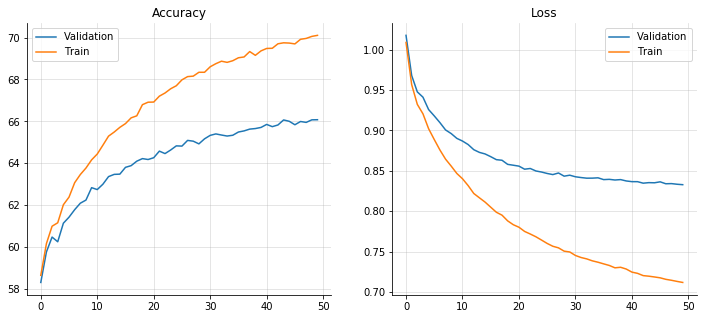

In [67]:
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(range(len(valAccVec)), valAccVec, label = "Validation")
ax1.plot(range(len(trainAccVec)), trainAccVec, label = "Train")
ax1.grid(True, alpha=0.4)
ax1.set_title("Accuracy")
ax1.legend()
ax2.plot(range(len(valLossVec)), valLossVec, label = "Validation")
ax2.plot(range(len(trainLossVec)), trainLossVec, label = "Train")
ax2.grid(True, alpha=0.4)
ax2.set_title("Loss")
ax2.legend()
plt.show()